In [1]:
!pip install pycoingecko

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests, json
import pycoingecko
from pycoingecko import CoinGeckoAPI
import time
from numpy.lib.polynomial import polyint
import datetime
from datetime import timedelta
import plotly.graph_objects as go
from IPython.core.display import display_svg
from numpy import *
import random
cg = CoinGeckoAPI()

**REAL TIME DATA REQUEST TEST:**

In [3]:
crt_price = cg.get_price(ids='bitcoin', vs_currencies='usd', include_24hr_vol=True)
print(crt_price['bitcoin']['usd'])

RetryError: ignored

#**REAL TIME SYSTEM:**

In [ ]:
price = cg.get_price(ids='bitcoin', vs_currencies='usd', include_24hr_vol=True)
current_price = price['bitcoin']['usd']

# list initialization:
price_list = [current_price,
              current_price,
              current_price,
              current_price,
              current_price,
              current_price,
              current_price,
              current_price,
              current_price,
              current_price]

rise_threshold = 10
fall_threshold = -10
sleep_time = 10
ratio_in = 0.3
ratio_out = 0.4
handling_fee_in = 0.01
handling_fee_out = 0.01
funds = 10000
BTC = 0

while True:
  # Update Prices:
  price = cg.get_price(ids='bitcoin', vs_currencies='usd', include_24hr_vol=True)
  current_price = price['bitcoin']['usd']
  price_list.append(current_price)
  print(f'>>>Current Price:{current_price}')

  # Judge the market:
  market_volatility = mean(price_list[-2:]) - mean(price_list[-4:-2])

  if  market_volatility > rise_threshold and funds > 0:
    buying_funds = round(funds * ratio_in, 2)
    buying_amount = round(buying_funds / ((1 + handling_fee_in) * current_price), 2)
    
    BTC = BTC + buying_amount
    funds = funds - buying_funds
    now = str(datetime.datetime.fromtimestamp(int(time.time())))
    print(f'{now} BTC+{buying_amount} BTC:{BTC} Funds:{funds} Current Assets:{BTC * current_price + funds}')
  
  elif market_volatility < fall_threshold and BTC > 0:
    sold_amount = round(BTC * ratio_out)
    sold_money = round(sold_amount * current_price * (1 - handling_fee_out))

    BTC = BTC - sold_amount
    funds = funds + sold_money
    now = str(datetime.datetime.fromtimestamp(int(time.time())))
    print(f'{now} BTC-{sold_amount} BTC:{BTC} Funds:{funds} Current Assets:{BTC * current_price + funds}')

  now = str(datetime.datetime.fromtimestamp(int(time.time())))
  print(f'{now} [Waitting...] BTC:{BTC} Funds:{funds} Current Assets:{BTC * current_price + funds}')
  time.sleep(sleep_time)
  

  



#**TRADE SIMULATOR**

**Generate Time Steps:**

In [ ]:
def EMA(df, period):
  ema = df.ewm(span=period, min_periods=period).mean()
  ema.dropna()
  return ema

period=72

ema['prices'].plot()

In [ ]:
print(ema)

NameError: ignored

In [4]:
# Generate time points:
df = pd.read_csv('./test_data.csv', index_col=0)
time_list = pd.date_range(df.index[0], df.index[-1], freq='5min')

# EMA Calculator:
def EMA(df, period):
  ema = df.ewm(span=period, min_periods=period).mean()
  ema.dropna()
  return ema

period=72



# time_signal = str(datetime.datetime.fromtimestamp(int(time.time())))
def Trader_robot_one(rise_threshold, fall_threshold, sleep_time,
                     ratio_in, ratio_out, handling_fee_in, handling_fee_out,
                     funds, BTC,
                     current_price, time_signal,
                     flag, price_list):

  print(f'>>>Current Price:{current_price}')
  now = time_signal
  
  # Calculate indicators, judge the market:
  # market_volatility = mean(price_list[-12:]) - mean(price_list[-24:-12])
  period = 72
  ema = EMA(pd.DataFrame(price_list), period)
  # print(ema.iloc[-1].isnull()[0])
  if ema.iloc[-1].isnull()[0] and ema.iloc[-2].isnull()[0]:
    market_volatility = 0
  else:
    market_volatility = ema.iloc[-1][0] - ema.iloc[-2][0]

  print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>', market_volatility)
  current_assets = BTC * current_price + funds
  money_output = 0
  decider = random.random()

  # Buying Condition:
  # if  market_volatility > rise_threshold and funds > 0:
  if market_volatility > 10 and funds > 0:
    buying_funds = funds * ratio_in
    buying_amount = buying_funds / ((1 + handling_fee_in) * current_price)
    BTC = BTC + buying_amount
    funds = funds - buying_funds
    current_assets = BTC * current_price + funds
    print(f'{now} [Buying...] BTC+{buying_amount} BTC:{BTC} Funds:{funds} Current Assets:{current_assets}\n')
  
  # Sold Condition:
  # elif market_volatility < fall_threshold and BTC > 0:
  # elif BTC * current_price * (1 + handling_fee_out) > 10 and BTC > 0:
  elif (current_price * BTC * (1 - handling_fee_out) + funds) > 10200 and BTC > 0:  
    sold_amount = BTC * ratio_out
    sold_money = sold_amount * current_price * (1 - handling_fee_out)
    BTC = BTC - sold_amount
    funds = funds + sold_money
    current_assets = BTC * current_price + funds
    print(f'{now} [Selling...] BTC-{sold_amount} BTC:{BTC} Funds:{funds} Current Assets:{current_assets}\n')
  else:
    # Waiting, do nothing:
    print(f'{now} [Waiting...] BTC:{BTC} Funds:{funds} Current Assets:{current_assets}\n')
    if funds - 10000 > 0:
      money_output = funds - 10000
      funds = 10000
    # time.sleep(sleep_time)
  return BTC, funds, current_assets, money_output, ema


# Trader parameters:
rise_threshold =200
fall_threshold = -70
sleep_time = 10
ratio_in = 0.3
ratio_out = 1
handling_fee_in = 0.01
handling_fee_out = 0.01
funds = 10000
BTC = 0


# Replay historical data:
trade_history = []


j = 0
flag = 0

for i in range(len(time_list)):
  if time_list[i] >= pd.to_datetime(df.index[j]):
    current_price = df['prices'].iloc[j]
    j = j + 1
  else:
    # print(time_list[i], current_price)
    # print(current_price)
    pass
  
  print(f'>>> {time_list[i]}  Price: {current_price}')
  time_signal = time_list[i]

  if flag == 0:
    price_list = list(np.ones(24) * current_price)
    flag = 1
  else:
    price_list.append(current_price)

  BTC, funds, current_assets, money_output, ema = Trader_robot_one(rise_threshold, fall_threshold, sleep_time,
                                                                   ratio_in, ratio_out, handling_fee_in, handling_fee_out,
                                                                   funds, BTC, current_price, time_signal, flag, price_list)
  flag = 1
  trade_history.append((time_signal, current_assets, funds, BTC, money_output))


trade_history = pd.DataFrame(trade_history, columns=['date_time', 'current_assets', 'funds', 'BTC', 'money_output'])
trade_history['date_time'] = pd.to_datetime(trade_history['date_time'])
trade_history.set_index(['date_time'], inplace=True)

串流輸出內容已截斷至最後 5000 行。
>>> 2022-09-12 12:45:00  Price: 21739.80437979554
>>>Current Price:21739.80437979554
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.01271080583683215
2022-09-12 12:45:00 [Waiting...] BTC:0.20706403776354287 Funds:5e-324 Current Assets:4501.5316750700185

>>> 2022-09-12 12:50:00  Price: 21739.80437979554
>>>Current Price:21739.80437979554
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.012362564579234459
2022-09-12 12:50:00 [Waiting...] BTC:0.20706403776354287 Funds:5e-324 Current Assets:4501.5316750700185

>>> 2022-09-12 12:55:00  Price: 21739.80437979554
>>>Current Price:21739.80437979554
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.01202386417935486
2022-09-12 12:55:00 [Waiting...] BTC:0.20706403776354287 Funds:5e-324 Current Assets:4501.5316750700185

>>> 2022-09-12 13:00:00  Price: 21739.80437979554
>>>Current Price:21739.80437979554
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 0.011694443244778086
2022-09-12 13:00:00 [Waiting...] BTC:0.20706403776354287 Funds:5e-324 Current Assets:4501.5316750700185

>>> 2022-09-12 13

Money Output:  0
Funds: 0.0
BTC: 0.20706
Assets: 4079.61 ( -5920.389999999999 )


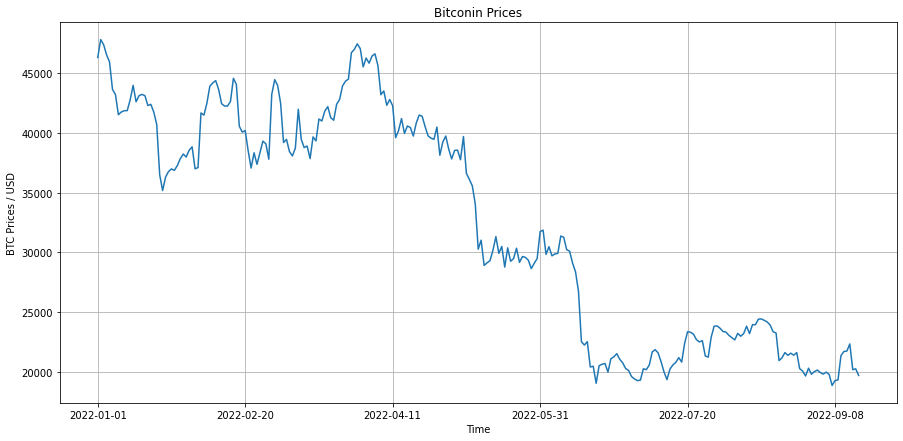

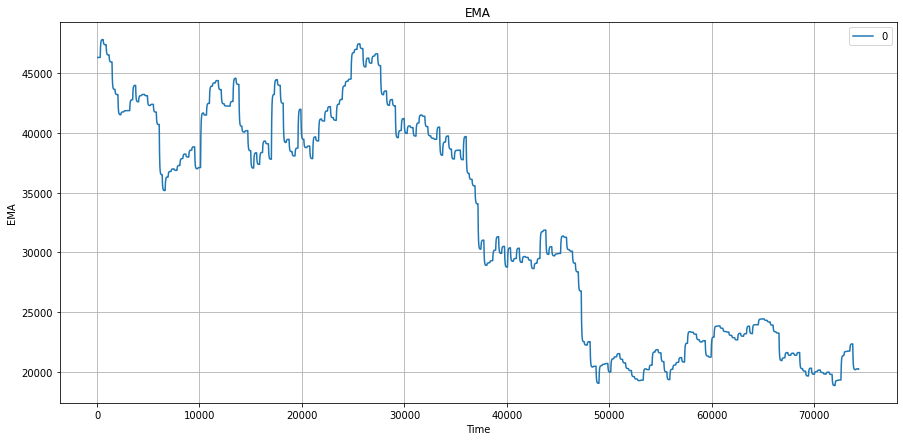

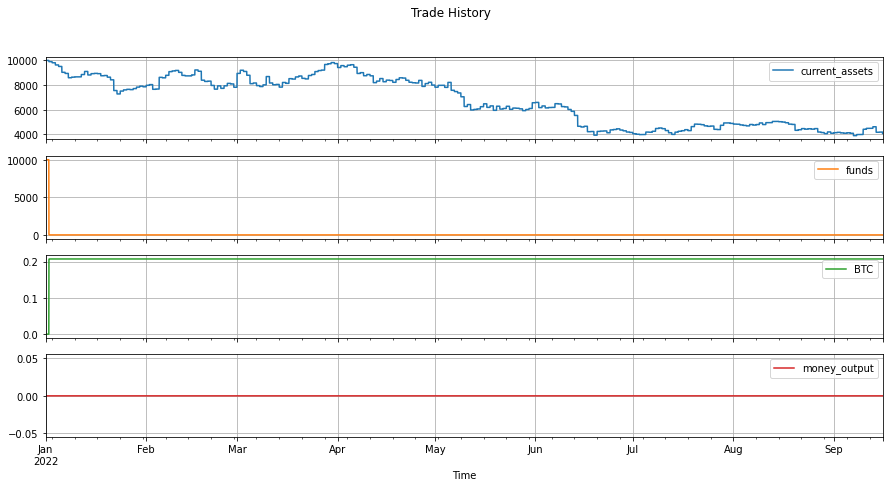

In [ ]:
df['prices'].plot(title='Bitconin Prices',
                  grid=True,
                  figsize=(15, 7),
                  xlabel='Time',
                  ylabel='BTC Prices / USD')

ema.plot(title='EMA',
         grid=True,
         figsize=(15, 7),
         xlabel='Time',
         ylabel='EMA')

trade_history[['current_assets', 'funds', 'BTC', 'money_output']].plot(grid=True,
                                                                              subplots=True,
                                                                              figsize=(15, 7),
                                                                              title='Trade History',
                                                                              xlabel='Time')

print('Money Output: ', round(sum(trade_history['money_output']), 2))
print('Funds:', round(trade_history['funds'][-1], 2))
print('BTC:', round(trade_history['BTC'][-1], 5))
print('Assets:', round(trade_history['current_assets'][-1], 2), '(', round(trade_history['current_assets'][-1], 2) - 10000, ')')
# plt.fill_between(trade_history.index, trade_history['current_assets'], trade_history['current_assets'], 10000, facecolor='b', alpha=0.4)